# 1. Imports and basic setup

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 2. Loading and preprocessing normal lens images

In [2]:
# load lens images from .npy file
original_images = np.load('lens_images.npy')
print("Dataset size:", len(original_images))

Dataset size: 1000


# 3. Creating a tensorflow dataset

In [3]:
# load again for debugging
original_images = np.load('lens_images.npy')
print("Original data shape:", original_images.shape)

# ensure images have the correct shape (samples, height, width, channels)
if len(original_images.shape) == 3:
    original_images = original_images[..., np.newaxis]  # Add channel dimension
print("Reshaped data:", original_images.shape)

# Normalize values between 0 and 1
if original_images.max() > 1.0:
    original_images = original_images / original_images.max()

# select validation images (10%)
val_size = int(0.1 * len(original_images))
val_images = original_images[:val_size]
train_images = original_images[val_size:]

print("Training data shape:", train_images.shape)
print("Validation data shape:", val_images.shape)

# Create datasets
batch_size = 8

train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = (
    train_dataset
    .shuffle(buffer_size=len(train_images))
    .batch(batch_size, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = tf.data.Dataset.from_tensor_slices(val_images)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)

# shape of a single batch
for batch in train_dataset.take(1):
    print("Single batch shape:", batch.shape)

Original data shape: (1000, 128, 128)
Reshaped data: (1000, 128, 128, 1)
Training data shape: (900, 128, 128, 1)
Validation data shape: (100, 128, 128, 1)
Single batch shape: (8, 128, 128, 1)


# 4. Defining the VAE

## 4.1 Sampling layer

Custom sampling layer

In [4]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * epsilon

## 4.2 Encoder

In [5]:
latent_dim = 32

encoder_inputs = keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)  
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)  
x = layers.BatchNormalization()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 32768)          │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │      4,194,432 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128)            │            512 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 32)             │          4,128 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 32)             │          4,128 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 32)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,296,768 (16.39 MB)

 Trainable params: 4,296,064 (16.39 MB)

 Non-trainable params: 704 (2.75 KB)

## 4.3 Decoder

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 128, activation="relu")(latent_inputs) 
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32768)               │       1,081,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,322,369 (5.04 MB)

 Trainable params: 1,321,921 (5.04 MB)

 Non-trainable params: 448 (1.75 KB)

## 4.4 VAE model with custom training step
we combine the encoder and decoder into a VAE class. In the VAE loss, we include

- reconstruction loss (e.g. MSE between original and reconstructed images)
- KL Divergence term to regularize the latent space

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # recon loss (MSE over all pixels)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.MSE(data, reconstruction)
            ) * 128 * 128  # Scale by image dimensions

            # KL Divergence with reduced weight
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            #  beta parameter to reduce impact of KL divergence
            beta = 0.1  
            total_loss = reconstruction_loss + beta * kl_loss

        # Calculate reconstruction error (MSE)
        reconstruction_error = tf.reduce_mean(
            keras.losses.MSE(data, reconstruction)
        )

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "reconstruction_error": reconstruction_error
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        # MSE over all pixels
        reconstruction_loss = tf.reduce_mean(
            keras.losses.MSE(data, reconstruction)
        ) * 128 * 128  # scale by image dimensions

        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )

        beta = 0.1
        total_loss = reconstruction_loss + beta * kl_loss

        reconstruction_error = tf.reduce_mean(
            keras.losses.MSE(data, reconstruction)
        )

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "reconstruction_error": reconstruction_error
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

# 5. Training the VAE

In [8]:
vae = VAE(encoder, decoder) # initialize VAE

# Compile model with Adam optimizer
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

# Train w/ validation data
epochs = 100

history = vae.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_reconstruction_error',
            mode='min',  
            patience=10,
            restore_best_weights=True
        )
    ]
)

# Access reconstruction error
train_reconstruction_error = history.history['reconstruction_error']
val_reconstruction_error = history.history['val_reconstruction_error']

Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - kl_loss: 297.8123 - loss: 1765.9594 - reconstruction_error: 0.1060 - reconstruction_loss: 1736.1782 - val_kl_loss: 136.6665 - val_loss: 135.1336 - val_reconstruction_error: 0.0074 - val_reconstruction_loss: 121.4669
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - kl_loss: 93.7364 - loss: 86.1831 - reconstruction_error: 0.0047 - reconstruction_loss: 76.8094 - val_kl_loss: 68.7963 - val_loss: 97.6312 - val_reconstruction_error: 0.0055 - val_reconstruction_loss: 90.7516
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - kl_loss: 54.0089 - loss: 70.5004 - reconstruction_error: 0.0040 - reconstruction_loss: 65.0995 - val_kl_loss: 39.4601 - val_loss: 73.0320 - val_reconstruction_error: 0.0042 - val_reconstruction_loss: 69.0860
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - kl_loss: 44.6894 - loss: 62.0833 - reconstruction_error: 0.0035 - reconstruction_loss: 57.6144 - val_kl_loss: 39.0875 - val_loss: 64.7189 - val

# 6. Comparing original and reconstructed images for normal lenses

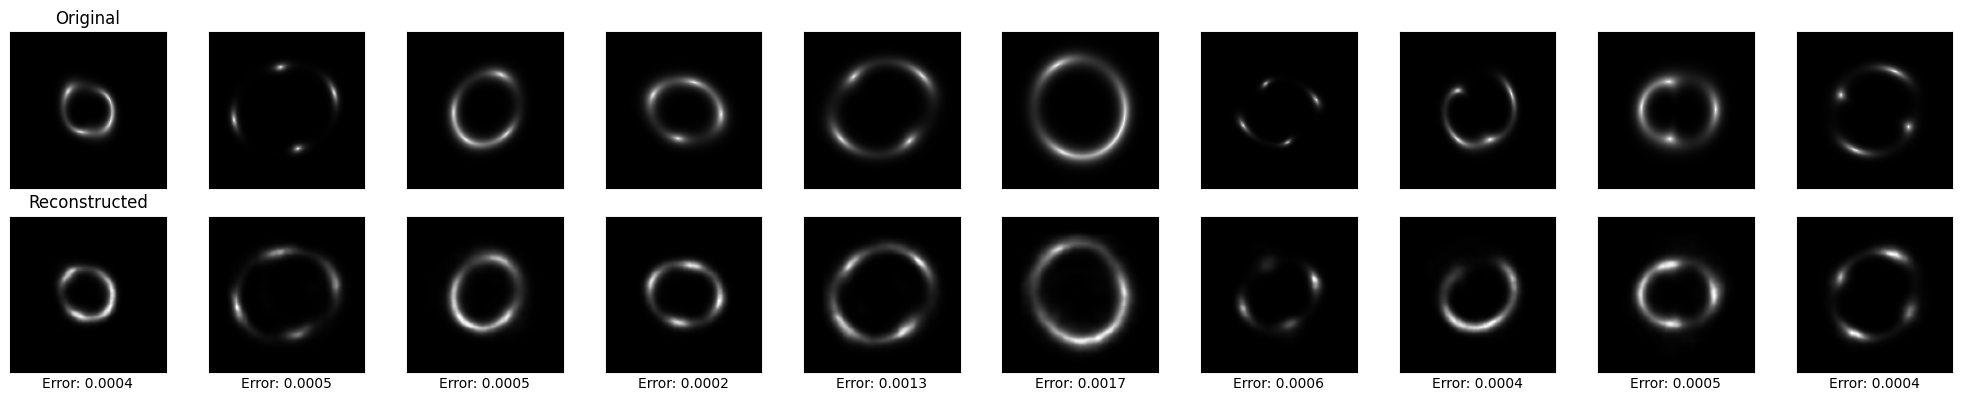

In [9]:

example_data = val_images[:10]  # first 10 validation images
reconstructions = vae(example_data)

# Calculate RE for each sample
reconstruction_errors = [
    tf.reduce_mean(keras.losses.MSE(example_data[i], reconstructions[i])).numpy()
    for i in range(len(example_data))
]

n = 10  
plt.figure(figsize=(2 * n, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(example_data[i].squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Original")

    # Reconstruction
    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(reconstructions[i].numpy().squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Reconstructed")

    # text: recon error
    ax.text(
        0.5, -0.1, f"Error: {reconstruction_errors[i]:.4f}",
        size=10, ha="center", transform=ax.transAxes
    )

plt.tight_layout()  
plt.show()

# 7. Loading and reconstructing anomalies

In [10]:
# load anomalous lenses
anomalous_images = np.load('anomalous_lens_images.npy')
print("Anomalous dataset size:", len(anomalous_images))

# Ensure images have the correct shape 
if len(anomalous_images.shape) == 3:
    anomalous_images = anomalous_images[..., np.newaxis]  # Add channel dimension
print("Anomalous data shape:", anomalous_images.shape)

# Normalize values 0 - 1 
if anomalous_images.max() > 1.0:
    anomalous_images = anomalous_images / anomalous_images.max()

# latent representations for normal and anomalous images
normal_z_means = []
normal_z_log_vars = []

for i in range(len(val_images)):
    img = val_images[i:i+1]
    z_mean, z_log_var, _ = vae.encoder(img)
    normal_z_means.append(z_mean.numpy())
    normal_z_log_vars.append(z_log_var.numpy())

# Stack them into arrays
normal_z_means = np.vstack(normal_z_means)
normal_z_log_vars = np.vstack(normal_z_log_vars)

# same for anomalous images
anomalous_z_means = []
anomalous_z_log_vars = []

for i in range(len(anomalous_images)):
    img = anomalous_images[i:i+1]
    z_mean, z_log_var, z = vae.encoder(img)
    anomalous_z_means.append(z_mean.numpy())
    anomalous_z_log_vars.append(z_log_var.numpy())

anomalous_z_means = np.vstack(anomalous_z_means)
anomalous_z_log_vars = np.vstack(anomalous_z_log_vars)

# Compute Mahalanobis distance
# 1, calculate mean and covariance of normal latent vectors
mean_normal = np.mean(normal_z_means, axis=0)
cov_normal = np.cov(normal_z_means, rowvar=False)

# 2, add small regularization to ensure covariance matrix is invertible
cov_normal += np.eye(cov_normal.shape[0]) * 1e-6

# 3, calculate Mahalanobis distance for each anomalous sample
from scipy.spatial.distance import mahalanobis
inv_cov = np.linalg.inv(cov_normal)

anomalous_mahalanobis = []
for i in range(len(anomalous_z_means)):
    dist = mahalanobis(anomalous_z_means[i].flatten(), mean_normal, inv_cov)
    anomalous_mahalanobis.append(dist)

normal_mahalanobis = []
for i in range(len(normal_z_means)):
    dist = mahalanobis(normal_z_means[i].flatten(), mean_normal, inv_cov)
    normal_mahalanobis.append(dist)

print("Sample anomalous Mahalanobis distances:", anomalous_mahalanobis[:5])
print("Sample normal Mahalanobis distances:", normal_mahalanobis[:5])

Anomalous dataset size: 100
Anomalous data shape: (100, 128, 128, 1)
Sample anomalous Mahalanobis distances: [10.161787299950259, 9.902390603114839, 8.764263937911918, 10.197964567871516, 8.952096676862936]
Sample normal Mahalanobis distances: [7.445645261003302, 7.2481618258849965, 6.301551066075582, 4.257451232187273, 7.204129029440307]


# 8. Visualizing all lenses and statistics

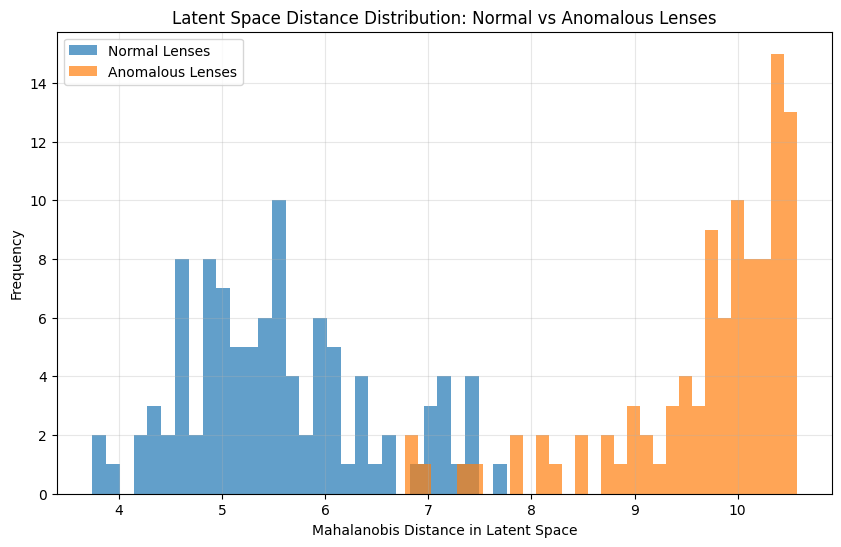

Mahalanobis distance threshold: 7.3746
Using Mahalanobis distance:
Correctly identified anomalies: 97/100 (97.00%)
Correctly identified normal samples: 96/100 (96.00%)


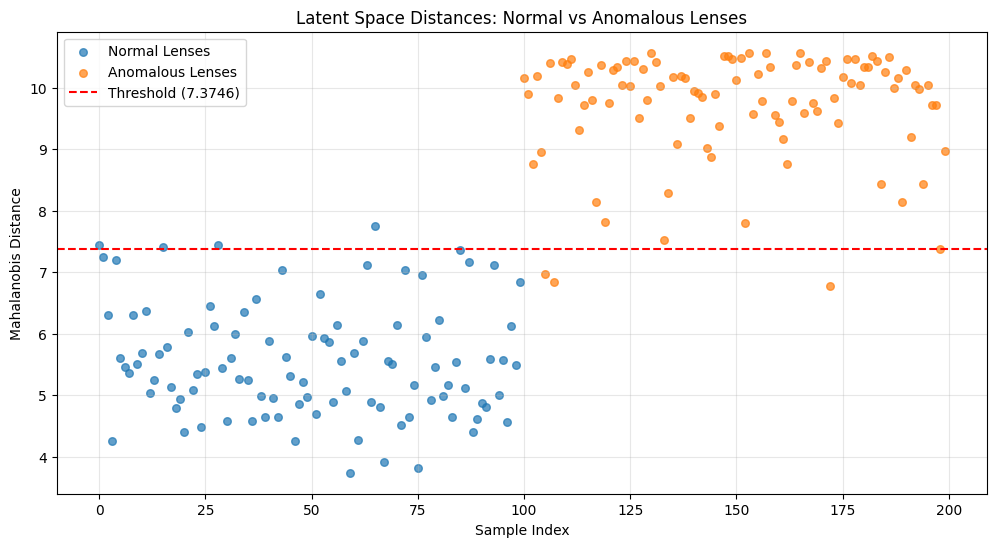

In [12]:
# compare Mahalanobis distance distributions
plt.figure(figsize=(10, 6))
plt.hist(normal_mahalanobis, bins=30, alpha=0.7, label='Normal Lenses')
plt.hist(anomalous_mahalanobis, bins=30, alpha=0.7, label='Anomalous Lenses')
plt.xlabel('Mahalanobis Distance in Latent Space')
plt.ylabel('Frequency')
plt.title('Latent Space Distance Distribution: Normal vs Anomalous Lenses')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# set threshold 
mahalanobis_threshold = np.mean(normal_mahalanobis) + 2 * np.std(normal_mahalanobis)
print(f"Mahalanobis distance threshold: {mahalanobis_threshold:.4f}")

#  detection metrics for plotting
true_anomalies_m = sum(dist > mahalanobis_threshold for dist in anomalous_mahalanobis)
false_normals_m = sum(dist <= mahalanobis_threshold for dist in anomalous_mahalanobis)
false_anomalies_m = sum(dist > mahalanobis_threshold for dist in normal_mahalanobis)
true_normals_m = sum(dist <= mahalanobis_threshold for dist in normal_mahalanobis)

print(f"Using Mahalanobis distance:")
print(f"Correctly identified anomalies: {true_anomalies_m}/{len(anomalous_mahalanobis)} ({true_anomalies_m/len(anomalous_mahalanobis)*100:.2f}%)")
print(f"Correctly identified normal samples: {true_normals_m}/{len(normal_mahalanobis)} ({true_normals_m/len(normal_mahalanobis)*100:.2f}%)")

# scatter plot 
plt.figure(figsize=(12, 6))
plt.scatter(range(len(normal_mahalanobis)), normal_mahalanobis,
           alpha=0.7, label='Normal Lenses', s=30)
plt.scatter(range(len(normal_mahalanobis),
                 len(normal_mahalanobis) + len(anomalous_mahalanobis)),
           anomalous_mahalanobis, alpha=0.7, label='Anomalous Lenses', s=30)
plt.axhline(y=mahalanobis_threshold, color='r', linestyle='--', label=f'Threshold ({mahalanobis_threshold:.4f})')
plt.xlabel('Sample Index')
plt.ylabel('Mahalanobis Distance')
plt.title('Latent Space Distances: Normal vs Anomalous Lenses')
plt.legend()
plt.grid(alpha=0.3)
plt.show()